<a href="https://colab.research.google.com/github/jrbobes/jrbobes-hitl-ml/blob/master/230829_PAAD_XAI_XOVETIC_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TCGA-PAAD - XAI - XOVETIC 2023**

author: jose.bobes at udc.es

# Importing required libraries

In [53]:
# Importing Required Libraries
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import numpy as np
print('numpy: {}'.format(np.__version__))

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import sklearn
print('sklearn: {}'.format(sklearn.__version__))

from sklearn import metrics

from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
scipy: 1.10.1
numpy: 1.23.5
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


# Cleaning the Pancreas dataset

In [2]:
# 1. Loading Data
url = "https://raw.githubusercontent.com/jrbobes/jrbobes-hitl-ml/master/tcga-paad-inicial.csv"
columns = ['ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'primary_diagnosis', 'tissue_or_organ_of_origin', 'age_at_index', 'gender', 'ethnicity', 'days_to_death', 'therapy_type']

dataset = pd.read_csv(url, sep=';', usecols=columns, encoding = "ISO-8859-1")

print(dataset.shape)
print(dataset.head())

(185, 11)
   therapy_type  age_at_index  days_to_death               ethnicity  gender  \
0         Other            53          486.0  not hispanic or latino  female   
1         Other            54          299.0  not hispanic or latino  female   
2         Other            58          545.0  not hispanic or latino  female   
3  Chemotherapy            66         1332.0  not hispanic or latino  female   
4         Other            64          117.0  not hispanic or latino    male   

  ajcc_pathologic_m ajcc_pathologic_n ajcc_pathologic_stage ajcc_pathologic_t  \
0                M0                N1             Stage IIB                T3   
1                MX                N0             Stage IIA                T3   
2                M1                N0              Stage IV                T3   
3                M0                N0             Stage IIA                T3   
4                M0                N0             Stage IIA                T3   

                  prim

In [3]:
# 2. Changing Datatype
for column, dtype in zip(dataset.columns, dataset.dtypes):
    print(f"{column}:{dtype}")

therapy_type:object
age_at_index:int64
days_to_death:float64
ethnicity:object
gender:object
ajcc_pathologic_m:object
ajcc_pathologic_n:object
ajcc_pathologic_stage:object
ajcc_pathologic_t:object
primary_diagnosis:object
tissue_or_organ_of_origin:object


In [4]:
# 3. Missing Values/ Null Values
dataset_null = dataset.isnull()
print(dataset.isnull().sum())

therapy_type                  0
age_at_index                  0
days_to_death                85
ethnicity                     0
gender                        0
ajcc_pathologic_m             0
ajcc_pathologic_n             1
ajcc_pathologic_stage         3
ajcc_pathologic_t             1
primary_diagnosis             0
tissue_or_organ_of_origin     0
dtype: int64


In [5]:
# 4. Fill in the missing values
dataset.days_to_death = dataset.days_to_death.fillna(18250) # Asignamos un valor muy alto (50 años)
dataset.ajcc_pathologic_stage = dataset.ajcc_pathologic_stage.fillna('TX')
dataset.ajcc_pathologic_t = dataset.ajcc_pathologic_t.fillna('TX')
dataset.ajcc_pathologic_m = dataset.ajcc_pathologic_m.fillna('MX')
dataset.ajcc_pathologic_n = dataset.ajcc_pathologic_n.fillna('NX')

dataset_null = dataset.isnull()
print(dataset.isnull().sum())

therapy_type                 0
age_at_index                 0
days_to_death                0
ethnicity                    0
gender                       0
ajcc_pathologic_m            0
ajcc_pathologic_n            0
ajcc_pathologic_stage        0
ajcc_pathologic_t            0
primary_diagnosis            0
tissue_or_organ_of_origin    0
dtype: int64


In [6]:
# 5. Removing Redundancy
count_duplicates = dataset[dataset.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 1


In [7]:
# There is one duplicate with the columns selected.
dataset[dataset.duplicated()]

,therapy_type,age_at_index,days_to_death,ethnicity,gender,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,primary_diagnosis,tissue_or_organ_of_origin
147,Chemotherapy,71,18250.0,not reported,male,M0,N1,Stage IIB,T3,"Infiltrating duct carcinoma, NOS",Head of pancreas


# Data Preparation

In [8]:
# 1. Simplify Target with only Chemotherapy or Other
dataset['therapy_type'] = dataset['therapy_type'].replace('Hormone Therapy', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Vaccine', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Ancillary', 'Other')

# check that we only get two values: 'Chemotherapy' and 'Other'
dataset['therapy_type'].unique()

array(['Other', 'Chemotherapy'], dtype=object)

In [9]:
# 3. Drop unneeded Features
# Remove therapy_type from the X vector, and keep it as the target.
X = dataset.drop(['therapy_type'], axis=1)
y = dataset['therapy_type']

In [10]:
# 4. Convert categorical variables into dummy/indicator variables.
# Categorical features need to be transformed before they can be used in a model.
# One-hot encoding is a common way to do this: We end up with a binary variable for each category.

# Encode Stage, T, N and M as numerical values (instead of Categorigal).
# TODO: asignar un valor numérico.

X_encoded = pd.get_dummies(X)

In [11]:
# 5. Split the data in train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3,random_state=42)

#TODO: convertir a tipo numérico los estados y TNM
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [12]:
# 6. Set the features to be taken into account when creating the models
feature_names = ['age_at_index', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'primary_diagnosis', 'tissue_or_organ_of_origin']

# Creating a Decision Tree model

In [13]:
# l. Create the Decision Tree model and fit the training data
dt_clf = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
dt_clf = dt_clf.fit(X_train, y_train)

In [14]:
# 2. Predict over the text data and show accuracy
y_dt_pre = dt_clf.predict(X_test)
dt_acc = accuracy_score(y_test, y_dt_pre)
print("Decision Tree accuracy: ", dt_acc)

Decision Tree accuracy:  0.7142857142857143


In [15]:
# 3. Get textual representation of the tree model
#Force the feature names to be a list: https://stackoverflow.com/questions/72178276/error-on-export-text-for-decision-tree-sklearn
dt_text_representation = tree.export_text(dt_clf,feature_names=X_encoded.columns.tolist())
print(dt_text_representation)

|--- days_to_death <= 157.50
|   |--- days_to_death <= 106.50
|   |   |--- ethnicity_not reported <= 0.50
|   |   |   |--- class: Other
|   |   |--- ethnicity_not reported >  0.50
|   |   |   |--- class: Chemotherapy
|   |--- days_to_death >  106.50
|   |   |--- class: Other
|--- days_to_death >  157.50
|   |--- ajcc_pathologic_stage_Stage IB <= 0.50
|   |   |--- ajcc_pathologic_m_MX <= 0.50
|   |   |   |--- class: Chemotherapy
|   |   |--- ajcc_pathologic_m_MX >  0.50
|   |   |   |--- class: Chemotherapy
|   |--- ajcc_pathologic_stage_Stage IB >  0.50
|   |   |--- ajcc_pathologic_n_NX <= 0.50
|   |   |   |--- class: Other
|   |   |--- ajcc_pathologic_n_NX >  0.50
|   |   |   |--- class: Chemotherapy



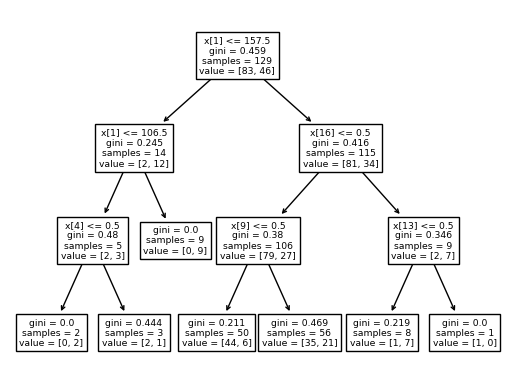

In [16]:
# 4. Get simple chart representation
tree.plot_tree(dt_clf)
plt.show()

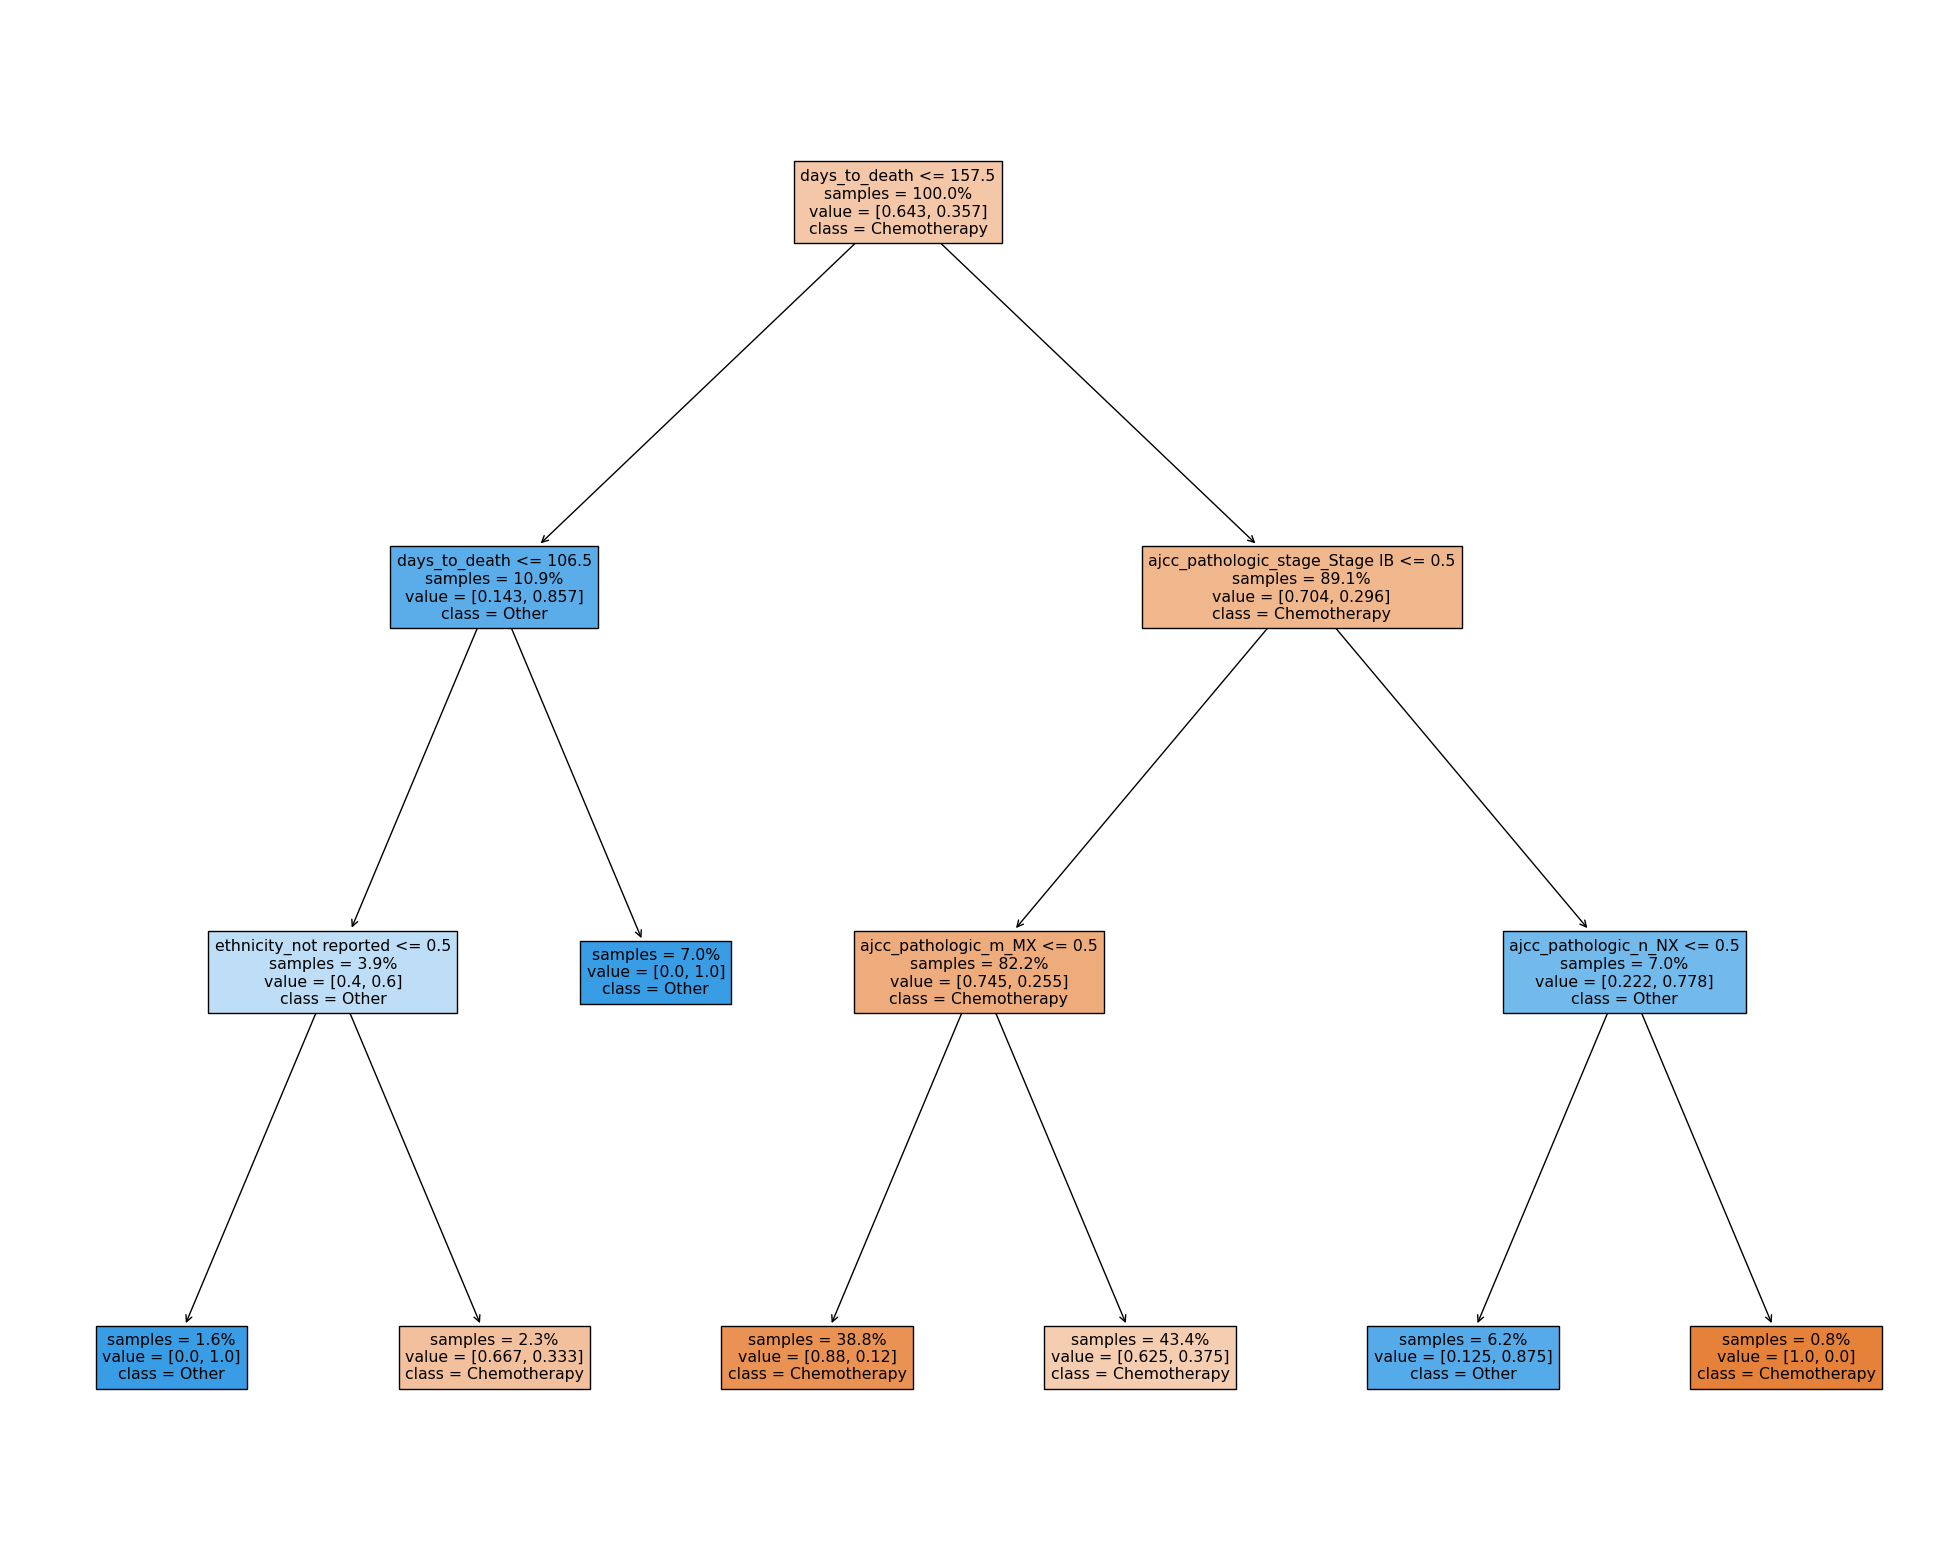

In [17]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_clf,
          feature_names=X_encoded.columns,
          class_names=['Chemotherapy','Other'],
          impurity=False,
          proportion=True,
          filled=True)
plt.show()

# Permutation Importance

Permutation Importance is an algorithm that computes importance scores
for each of the feature variables of a dataset. The importance measures are determined by computing the sensitivity of a model to random permutations of feature values.

It measures the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature.

In [18]:
# 1. Install required package
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [19]:
# 2. Get permitation importance data
perm = PermutationImportance(dt_clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_encoded.columns.tolist())

Weight,Feature
0.0714 ± 0.0875,days_to_death
0.0571 ± 0.0416,ajcc_pathologic_stage_Stage IB
0.0143 ± 0.0143,ethnicity_not reported
0.0071 ± 0.0175,ajcc_pathologic_n_NX
0 ± 0.0000,age_at_index
0 ± 0.0000,ethnicity_not hispanic or latino
0 ± 0.0000,gender_female
0 ± 0.0000,gender_male
0 ± 0.0000,ajcc_pathologic_m_M0
0 ± 0.0000,ajcc_pathologic_m_M1


In [20]:
# Visualize graph with graphviz library
#import graphviz
#dot_data = tree.export_graphviz(dt_clf, out_file=None, feature_names= X_encoded.columns, class_names=['Chemotherapy', 'Other'], filled=True)
#graph = graphviz.Source(dot_data, format="png")
#graph

# Creating a Random Forest model

In [21]:
# Building Random Forest Model

# Create Random Forest classifer object
rf_clf = RandomForestClassifier(bootstrap=True)
#TODO: analizar el parámetro "n_estimators"

# Train Random Forest Classifer
rf_estimator = rf_clf.fit(X_train, y_train)

In [25]:
#Predict the response for test dataset
#OPCION 1: y_pred = rf.predict(X_encoded)
y_rf_pred = rf_clf.predict(X_test)

dt_acc = accuracy_score(y_test, y_rf_pred)
print("Random Forrest Tree accuracy: ", dt_acc)

Random Forrest Tree accuracy:  0.7142857142857143


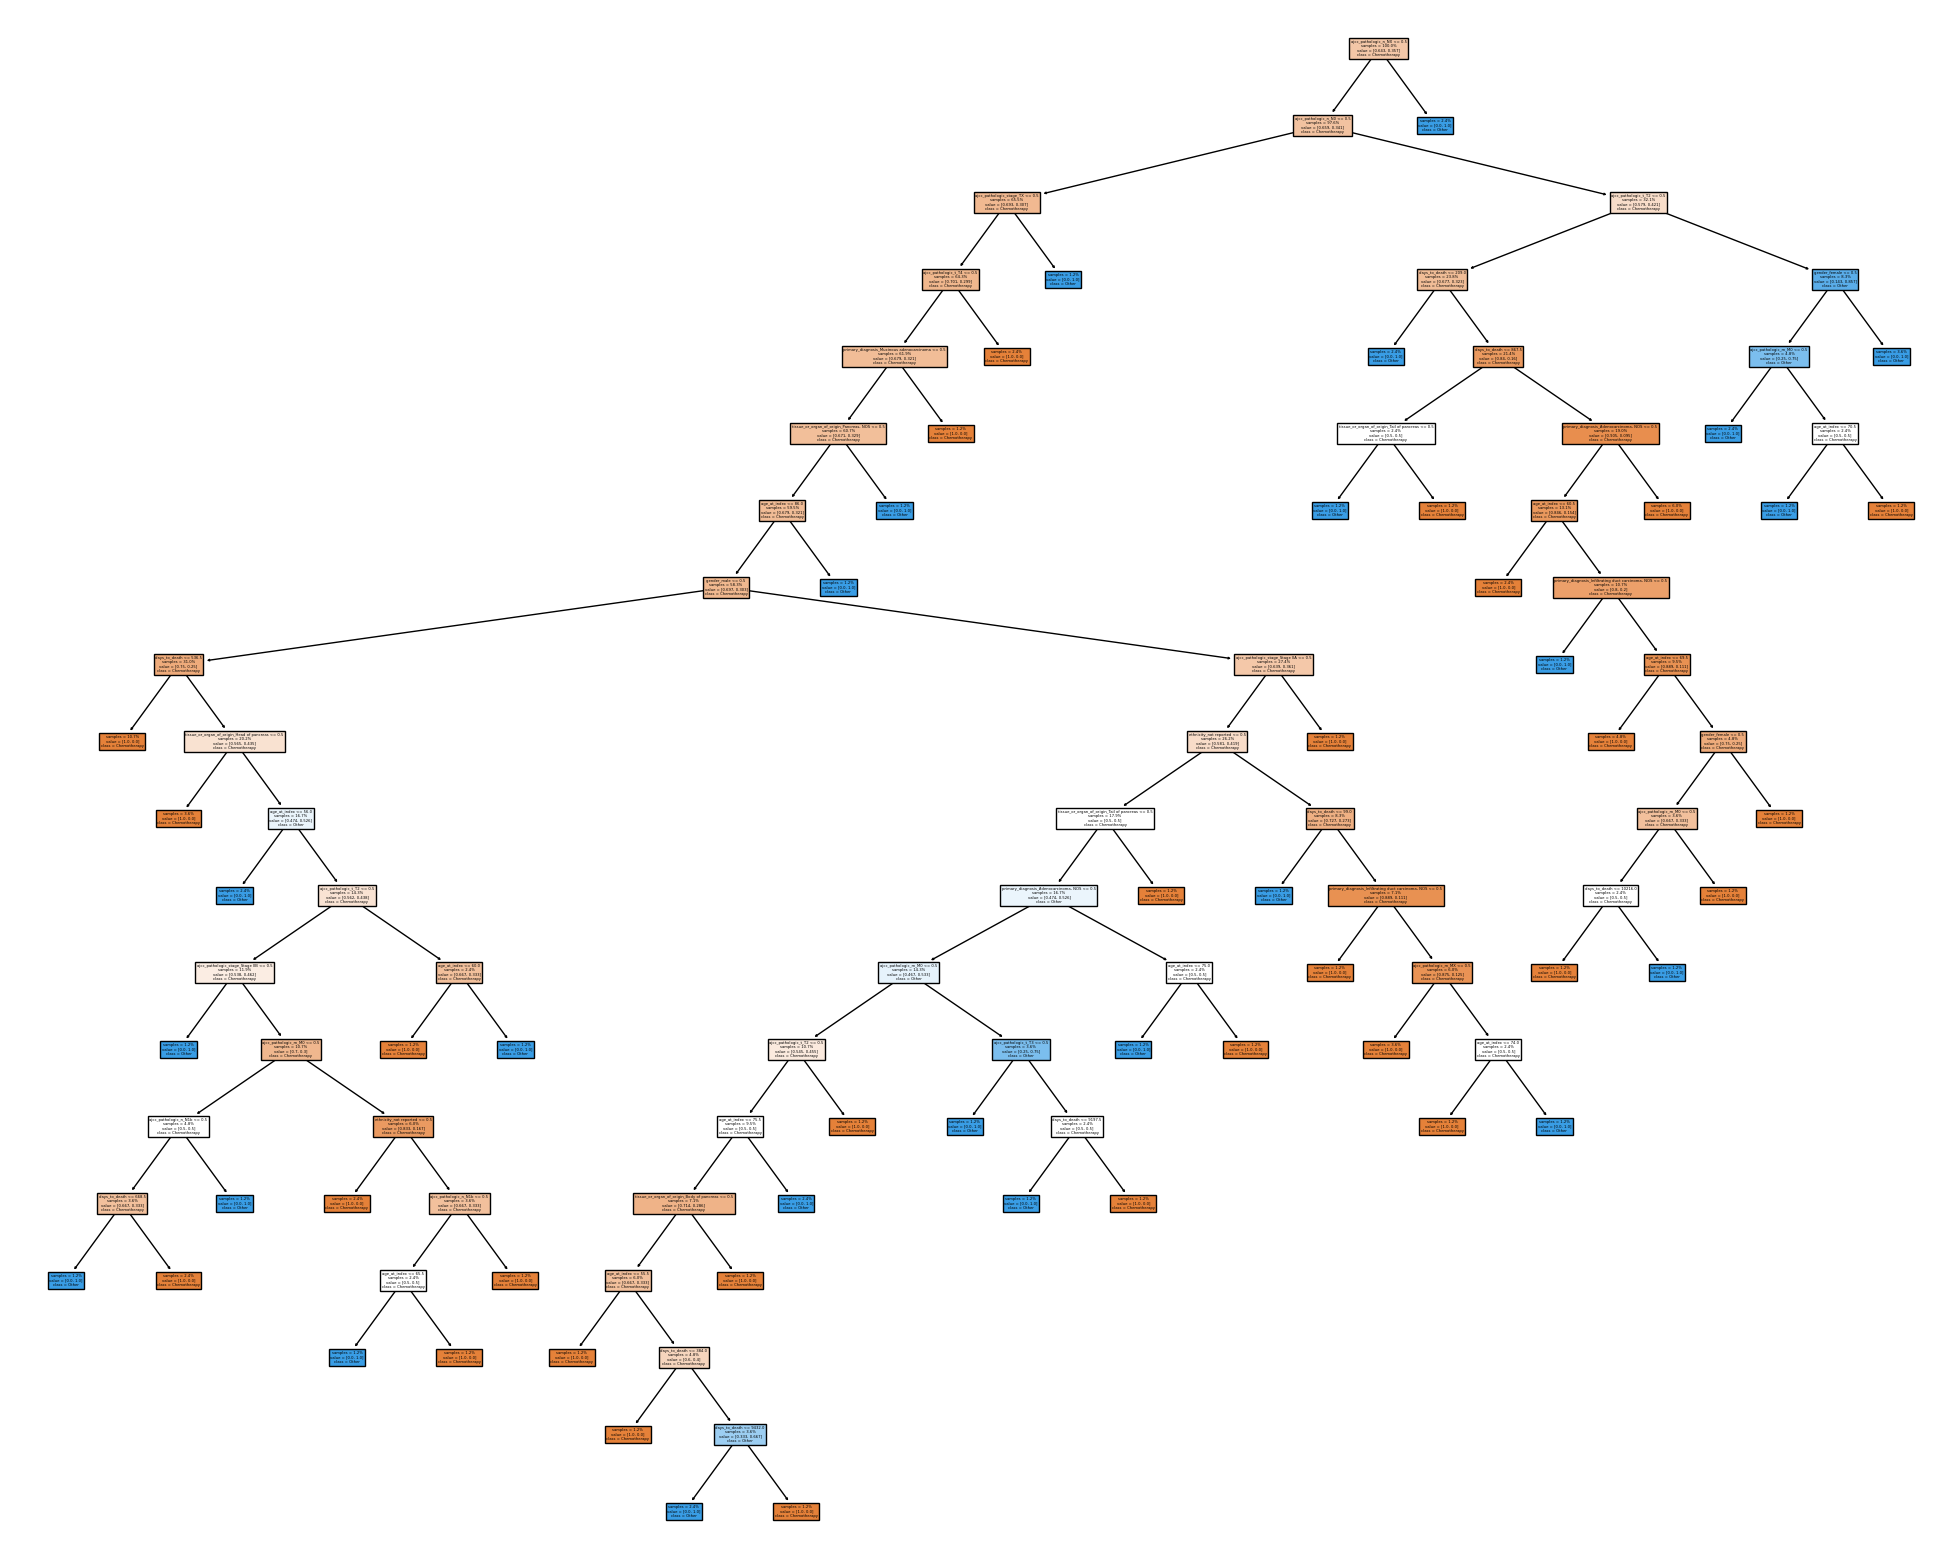

In [26]:
# Visualizing the decision tree
fig_rf = plt.figure(figsize=((25,20)))
tree.plot_tree(rf_estimator.estimators_[0],
            feature_names = X_encoded.columns,
            class_names=['Chemotherapy','Other'],
            impurity=False,
            proportion=True,
            filled=True)
fig_rf.savefig('rf_tree.png')
plt.show()

# Create a XGBClassifier model

In [45]:
# 1. Create a XGBClassifier model
import xgboost as xgb

y_train[y_train == 'Other'] = 0
y_train[y_train == 'Chemotherapy'] = 1

y_test[y_test == 'Other'] = 0
y_test[y_test == 'Chemotherapy'] = 1

xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            max_depth=2,
                            n_estimators=10)
xgb_estimator = xgb_clf.fit(X_train, y_train)

In [64]:
# 2. Predict the response for test dataset
y_xgb_pred = xgb_clf.predict(X_test)
# TODO error al intentar obtener la precisión: https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
#xgb_acc = accuracy_score(y_test, y_xgb_pred)
#print("XGBOOST accuracy: ", dt_acc)

In [66]:
#xgb_explainer = shap.Explainer(xgb_clf)
#shap_values = xgb_explainer(X_encoded)

# waterfall plot for first observation
#shap.plots.waterfall(xgb_explainer.expected_value[1])

# Exaplainability with SHAP

In [ ]:
!pip install shap
import shap

# Explain the model's predictions using SHAP
explainerShap = shap.TreeExplainer(rf)
shap_values = explainerShap.shap_values(X_encoded)

**Pacient 3**
Get the data from patient 3

In [ ]:
paciente3 = X_encoded.loc[[2]]
paciente3

In [ ]:
shap.initjs()
paciente3_shap_values = explainerShap.shap_values(paciente3)

shap.force_plot(explainerShap.expected_value[1], paciente3_shap_values[1], paciente3, matplotlib = True, show=False)

In [ ]:
plt.savefig("shap_paciente3.png")
plt.close()

Paciente 4

In [ ]:
paciente4 = X_encoded.loc[[3]]
paciente4

In [ ]:
#shap.initjs()

paciente4_shap_values = explainerShap.shap_values(paciente4)
shap.force_plot(explainerShap.expected_value[1], paciente4_shap_values[1], paciente4, matplotlib = True, show=False)

In [ ]:
plt.savefig("shap_paciente4.png")
plt.close()

Summary plot will give us the variable importance plot. Features with high predicting power are shown at the top and the ones with low predicting powers are shown at the bottom.

In [ ]:
shap.summary_plot(shap_values, X_encoded, plot_type='bar', class_names=['Chemotherapy','Other'])

In [ ]:
# Summary plot in an individual sample
shap.summary_plot(shap_values[0], X_encoded)

The **partial dependence plot** is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

In [ ]:
shap.dependence_plot(0, shap_values[1], X_encoded, feature_names = X_encoded.columns)

A continuación incluimos un gráfico de decisión:

In [ ]:
i=1
shap.decision_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

Y finalmente un gráfico de fuerzas:

In [ ]:
shap.initjs()
i = 1
shap.force_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

# Explainability with LIME

In [ ]:
# Install SHAP (SHapley Additive exPlanations).
!pip install lime

# Import required libraries
import lime
import lime.lime_tabular

In [ ]:
# XAI with LIME (Local Interpretable Model-agnostic Explanations)
explainerLime = lime.lime_tabular.LimeTabularExplainer(X_encoded.values, feature_names=X_encoded.columns, class_names = ['Chemotherapy', 'Other'], discretize_continuous=True)

exp = explainerLime.explain_instance(X_encoded.values[2], rf.predict_proba, num_features=10, top_labels=3)
exp.show_in_notebook(show_all=True)
exp.as_pyplot_figure()
